Given link flows and capacity constraints, this function finds a feasible set of link flows. The inputs to the function are:

f(vector): given (possibly infeasible) link flows

u(vector): link capacity constraints to be met

delta(matrix): link*route incidence matrix

od2route(matrix): K*max_r gives indices of all routes for a given od pair

The output of the function is 

f_feas(vector): feasible link flows for given capacity constraints

In [1]:
debug = False
def find_feasible(f,u,delta,od2route):
    import numpy as np
    delta = np.matrix(delta)
    u = np.array(u)
    
    l = np.shape(f)[0] #number of links in network
    K = np.shape(od2route)[0] #number of od pairs in network
    r = np.shape(delta)[1] #number of routes in network
    d = np.zeros((l,r))
    f_feas = f #vector of feasible flows satisfying capacity constraints
    for k in range(K):
        if debug:
            print('OD pair: %d'%(k+1))
        r_k = od2route[k,:] #vector of indices of all routes bw od pair k
        if isinstance(r_k,list): 
            r_k = r_k[0]
        r_k = r_k[np.invert(np.isnan(r_k))] #take only existing routes
        r_k = r_k.astype(int)
        if debug:
            print('Routes %s'%r_k)
        flag1 = [f_feas>u] 
        sat_f = np.nonzero(flag1)[1] #indices of saturated flows
        d = (delta>0) #binary link route incidence matrix
        d = d*1
        #update the incidence matrix to find saturated flows
    
        # for R in r_k:
        for i in sat_f:
            d[i,:] = 2 * d[i,:]
        #        if d[i,R]>0:
        #            d[i,R] = d[i,R]+1 #matrix indicating routes with saturated links
                    #0: link not in route, 1: unsaturated link, 2: saturated link
        sat = np.where(np.max(d[:,r_k],axis=0)==2)[1] #saturated routes
        unsat = np.where(np.max(d[:,r_k],axis=0)==1)[1] #unsaturated routes
        if np.size(sat)==0 and debug:#if no saturated route is present for a given od pair
            print('No saturated route for OD pair: %d'%(k+1))
        
        else:#presence of at least one saturated route
            f_r = 1.0
            for r in sat:#For each saturated route
                if (np.max(d[:,r],axis=0)==2)&(f_r>0):
                    l_r = np.where(d[:,r]>0)[0] #links in saturated route r
                    f_r = max(f_feas[l_r]-u[l_r]) #flow to be rerouted from saturated route r
                    flag = 1
                    while flag: # as long as the route r remains saturated
                        unsat = np.where(np.max(d[:,r_k],axis=0)==1)[1] #unsaturated routes
                        cap = np.zeros(np.size(unsat))
                        c = 0
                        for us in unsat: #compute extra capacity for unsaturated routes
                            l_u = np.where(d[:,us]>0)[0] #links in unsaturated route u
                            cap[c] = min(u[l_u]-f_feas[l_u]) #extra capacity of unsaturated route u
                            c = c+1
                        i_unsat_sort = np.flip(np.argsort(cap),0) #unsaturated routes sorted in decreasing order of capacities
                        cap_sort = cap[i_unsat_sort] 
                        if f_r<=cap_sort[0]: #all flow to be rerouted can be put in one unsat route
                            f_feas[np.where(d[:,r]>0)[0]] = f_feas[np.where(d[:,r]>0)[0]]-f_r #remove f_r from sat route r
                            f_feas[np.where(d[:,unsat[i_unsat_sort[0]]]>0)[0]] = f_feas[np.where(d[:,unsat[i_unsat_sort[0]]]>0)[0]]+f_r #move f_r to route with highest capacity
                            gl = np.where(d[:,r]==2)[0]
                            d[np.where(d[:,r]>0)[0],r] = 1
                            d[gl,np.where(d[gl,:]>0)[1]] = 1
                            flag = 0
                        else: #split flow to be rerouted
                            f_feas[np.where(d[:,r]>0)[0]] = f_feas[np.where(d[:,r]>0)[0]]-cap_sort[0] #remove cap_sort[0] from sat route r
                            f_feas[np.where(d[:,unsat[i_unsat_sort[0]]]>0)[0]] = f_feas[np.where(d[:,unsat[i_unsat_sort[0]]]>0)[0]]+cap_sort[0] #move f_r to route with highest capacity
                            f_r = f_r-cap_sort[0]
                            flag = 1
    if debug:
        print('Capacities:')
        print(u)
        print('Feasible flows:')
        print(f_feas)
    return f_feas

In [2]:
import numpy as np
f = np.matrix([3.5,1,2.5,1,3.5])
f = f.reshape((5,1))
u = np.matrix([10.0,10.0,2.0,10.0,10.0])
u = u.reshape((5,1))
delta = np.matrix([[1,1,0],[0,0,1],[0,1,0],[1,0,0],[0,1,1]])
od2route = np.array([[0,1,2]])

In [3]:
f_feas = find_feasible(f,u,delta,od2route)

In [4]:
import numpy as np
f = np.matrix([4.0,2.0,3.0,1.0,5.0])
f = f.reshape((5,1))
u = np.matrix([10.0,10.0,2.0,10.0,10.0])
u = u.reshape((5,1))
delta = np.matrix([[1,1,0,1,0],[0,0,1,0,1],[0,1,0,1,0],[1,0,0,0,0],[0,1,1,0,0]])
od2route = np.array([[0,1,2],[3,4,np.nan]])
f_feas = find_feasible(f,u,delta,od2route)

In [5]:
def inv_route_to_od(route2od):
    nb_od = np.max(route2od) + 1
    od2route = {}
    nb_path_max_od_tmp = np.zeros(nb_od, dtype=int)
    for i in range(len(route2od)):
        if route2od[i] not in od2route.keys():
            od2route[route2od[i]] = set()
        od2route[route2od[i]].add(i)
        nb_path_max_od_tmp[route2od[i]] += 1

    nb_path_max_od = np.max(nb_path_max_od_tmp)
    od2route_tmp = np.ones((nb_od, nb_path_max_od)) * np.nan
    for i in od2route.keys():
        for j in range(len(od2route[i])):
            od2route_tmp[i][j] = od2route[i].pop()
    return od2route_tmp

In [6]:
import Frank_Wolf_solver
I210 = 'data/I210'
Chic = 'data/Chicago'
Anah = 'data/Anaheim'
Siou = 'data/SiouxFalls'
Brae = 'data/braess'

network_name = Brae
graph, demand = Frank_Wolf_solver.load_network(network_name)

eps=1e-8
nb_iter = 1000

nb_point = 6
obj_feas = np.zeros(nb_point)
obj_sol = np.zeros(nb_point)
cap_array = np.zeros(nb_point)
for cap_tmp in range(nb_point):
    cap = cap_tmp + 1
    c = -1
    if network_name == Brae:
        demand[0][2] = 10
        u = [11, 11, cap, 11, 11]

    path_flow_matrix, tt_f, delta, route2od = Frank_Wolf_solver.Frank_Wolf_solver(graph, demand, eps, nb_iter, c)
    delta = delta.T
    f = delta @ path_flow_matrix
    od2route = inv_route_to_od(route2od)

    f_feas = find_feasible(f,u,delta,od2route)
    path_flow_matrix, tt_f, delta, route2od = Frank_Wolf_solver.Frank_Wolf_solver(graph, demand, eps, nb_iter, u)
    delta = delta.T
    f_sol = delta @ path_flow_matrix
    
    obj_feas[cap_tmp] = Frank_Wolf_solver.potential(graph, f_feas)
    obj_sol[cap_tmp] = Frank_Wolf_solver.potential(graph, f_sol)
    cap_array[cap_tmp] = cap

    print()
    print(cap)
    print("Comparing the solutions:")
    print("Objective solution: " + str(Frank_Wolf_solver.potential(graph, f_sol)))
    print("Objective estimate: " + str(Frank_Wolf_solver.potential(graph, f_feas)))
    print("Link flow solution: " + str(f_sol))
    print("Link flow feasible flow: " + str(f_feas))
    print("Path flow solution: " + str(path_flow_matrix))
    print("Path flow feasible flow: " + str(np.linalg.pinv(delta) @ f_feas))
    
if debug:
    print()
    print("Comparing the solutions:")
    print("Objective solution: " + str(Frank_Wolf_solver.potential(graph, f_sol)))
    print("Objective estimate: " + str(Frank_Wolf_solver.potential(graph, f_feas)))
    print("Link flow solution: " + str(f_sol))
    print("Link flow feasible flow: " + str(f_feas))
    print("Path flow solution: " + str(path_flow_matrix))
    print("Path flow feasible flow: " + str(np.linalg.pinv(delta) @ f_feas))



1
Comparing the solutions:
Objective solution: 32.275001024090166
Objective estimate: 32.49999744127699
Link flow solution: [5.49999716 4.50000284 0.99999488 4.50000228 5.49999772]
Link flow feasible flow: [4.00000853 5.99999147 1.         3.00000853 6.99999147]
Path flow solution: [0.99999488 4.50000228 4.50000284]
Path flow feasible flow: [1.         3.00000853 5.99999147]

2
Comparing the solutions:
Objective solution: 32.100000291101786
Objective estimate: 32.325000440595716
Link flow solution: [5.99999716 4.00000284 1.99999806 3.99999911 6.00000089]
Link flow feasible flow: [4.49999853 5.50000147 2.         2.49999853 7.50000147]
Path flow solution: [1.99999806 3.99999911 4.00000284]
Path flow feasible flow: [2.         2.49999853 5.50000147]

3
Comparing the solutions:
Objective solution: 31.97500051883101
Objective estimate: 32.075000293730554
Link flow solution: [6.4999994  3.5000006  2.99999481 3.50000459 6.49999541]
Link flow feasible flow: [5.49999853 4.50000147 3.         

In [7]:
import matplotlib.pyplot as plt

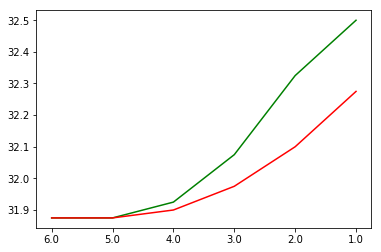

In [8]:
plt.plot(cap_array[::-1], obj_feas, color='green')
plt.plot(cap_array[::-1], obj_sol, color='red')
plt.xticks(cap_array, cap_array[::-1])
plt.show()